In [1]:
import os
import csv
import sys
import json
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import roc_auc_score

from collections import defaultdict

%matplotlib inline

In [2]:
sys.path.append('../src')
import plot_helpers as ph
pd.set_option('display.precision', 3)

In [3]:
experiment_id = "7"
experiment = json.load(open('../analysis.json'))["experiments"][experiment_id]

In [4]:
from IPython.display import Markdown as md
md(f"""
## {experiment['name']}

### Description
{experiment['description']}

### Results
- 1e-5 yields the best performance overall, slightly better than 1e-6
""")


## Explore learning rates, ClinicalBERT.

### Description
Evalaute several different learning rates for their impact on overall performance.

### Results
- 1e-5 yields the best performance overall, slightly better than 1e-6


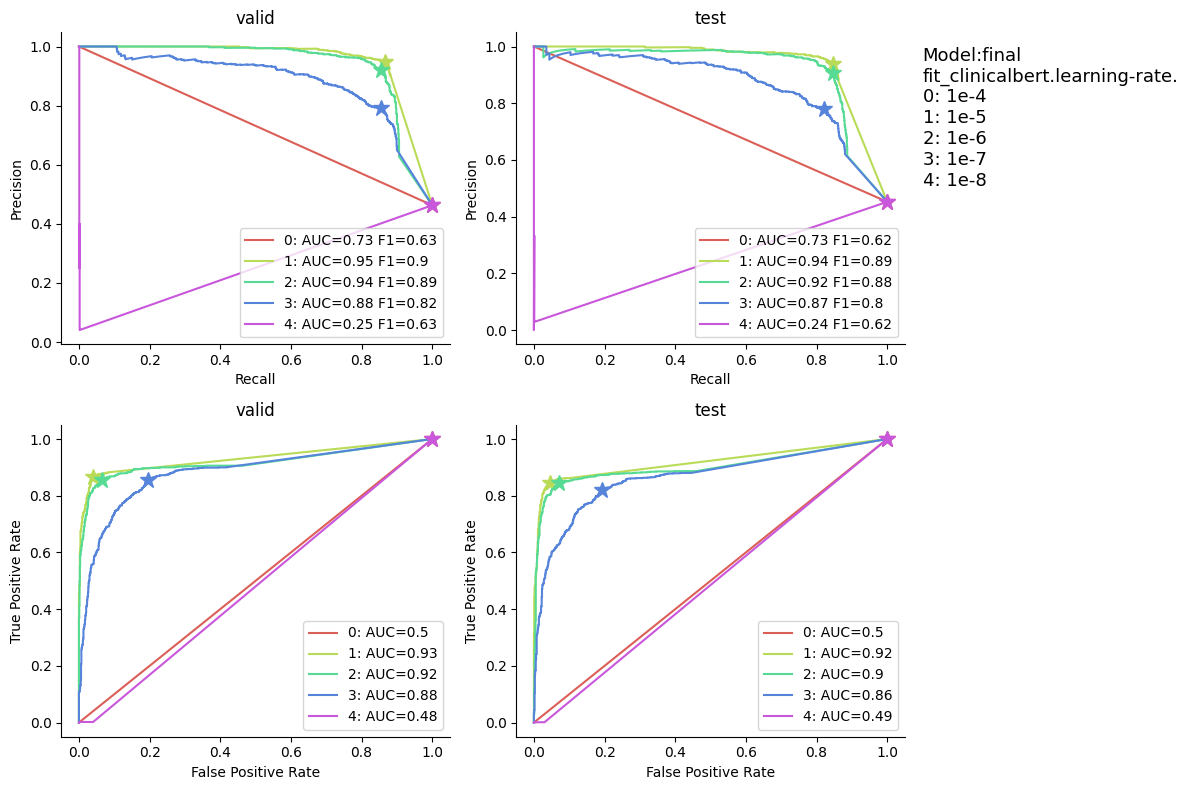

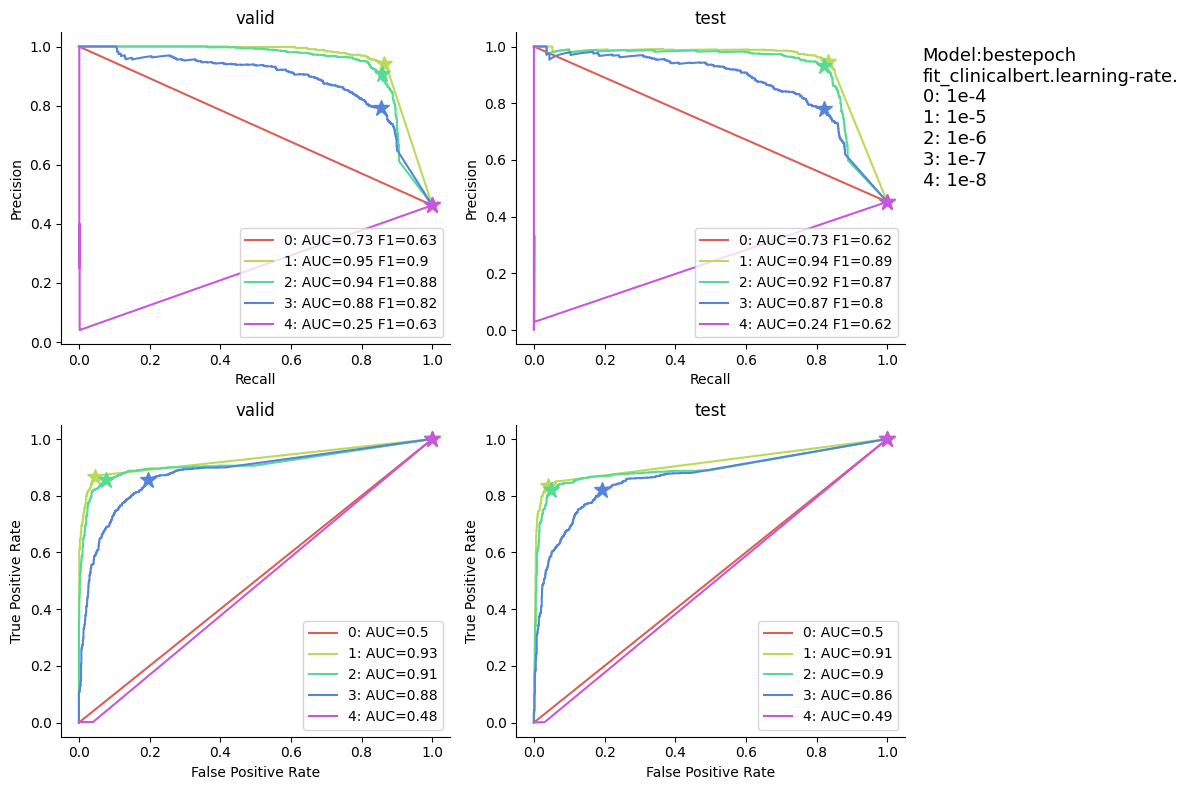

In [5]:
perfdata = defaultdict(lambda: defaultdict(list))

for modeltype in ('final', 'bestepoch'):
    resfiles = experiment[modeltype]
    colors = sns.color_palette("hls", len(resfiles))

    plt.figure(figsize=(12,8))
    plotcounter = 1


    for split in ('valid', 'test'):
        plt.subplot(2, 2, plotcounter)
        plotcounter += 1
        plt.title(split)

        for i, resfile in enumerate(resfiles):

            df = pd.read_csv(os.path.join('..', resfile), index_col=0)
            df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
            split_df = df[df['split']==split]

            prdata = ph.prdata(split_df['label'], split_df['Pred1'])
            perfdata[(modeltype, split)]['prdata'].append(prdata)
            
            plt.plot(prdata['recall'], prdata['precision'], color=colors[i], 
                     label=f'{i}: AUC={prdata["pr_auc"]:.2} F1={prdata["max_f1"]:.2}'
                    )
            plt.plot([prdata['max_f1_recall']], [prdata['max_f1_precision']], '*', color=colors[i], markersize=12)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        sns.despine()

    for split in ('valid', 'test'):
        plt.subplot(2, 2, plotcounter)
        plotcounter += 1
        plt.title(split)

        for i, resfile in enumerate(resfiles):

            df = pd.read_csv(os.path.join('..', resfile), index_col=0)
            df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
            split_df = df[df['split']==split]

            prdata = ph.prdata(split_df['label'], split_df['Pred1'])
            rocdata = ph.rocdata(split_df['label'], split_df['Pred1'], prdata['max_f1_threshold'])
            perfdata[(modeltype, split)]['rocdata'].append(rocdata)
            
            plt.plot(rocdata['fpr'], rocdata['tpr'], color=colors[i], 
                     label=f'{i}: AUC={rocdata["roc_auc"]:.2}'
                    )
            plt.plot([rocdata['max_f1_fpr']], [rocdata['max_f1_tpr']], '*', color=colors[i], markersize=12)

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        sns.despine()

    plt.subplot(2, 2, 2)
    reflegend = f'Model:{modeltype}\n{experiment["factor"]}\n' + '\n'.join([f"{i}: {s}" for i, s in enumerate(experiment['labels'])])
    plt.text(1.1, 1.0, reflegend, fontsize=13, verticalalignment='top')
    #plt.suptitle(modeltype)
    plt.tight_layout()
    
    plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}.pdf')

0.365780621767044


,Factor,Valid Precision,Valid Recall,Valid F1,Valid AUPR,Valid AUROC,Threshold,Test Precision,Test Recall,Test F1,Test AUPR,Test AUROC
0,1e-4,0.463,1.000,0.633,0.731,0.500,0.000,0.452,1.000,0.623,0.726,0.500
1,1e-5,0.942,0.864,0.901,0.954,0.928,0.366,0.947,0.833,0.886,0.939,0.914
2,1e-6,0.906,0.856,0.880,0.936,0.914,2.381,0.932,0.822,0.873,0.919,0.899
3,1e-7,0.791,0.855,0.822,0.883,0.881,0.779,0.780,0.821,0.800,0.867,0.863
4,1e-8,0.463,1.000,0.633,0.253,0.481,0.000,0.452,1.000,0.623,0.240,0.486


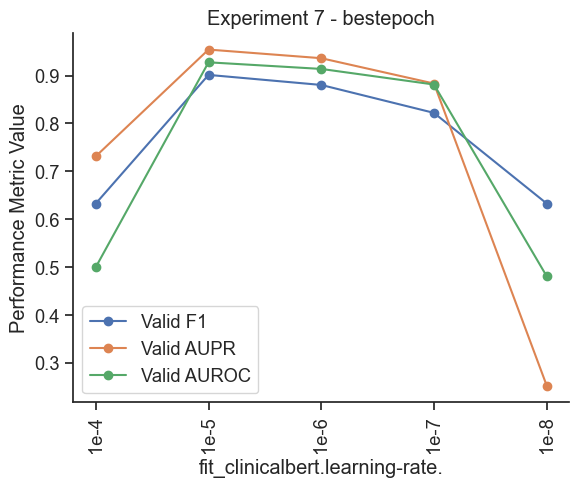

In [6]:
modeltype = 'bestepoch'
key = (modeltype, 'valid')
dfdata = {
    'Factor': experiment['labels'],
    'Valid Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Valid Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Valid F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Valid AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Valid AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
    'Threshold': [d['max_f1_threshold'] for d in perfdata[key]['prdata']]
}

valid = pd.DataFrame(dfdata)

key = (modeltype, 'test')
dfdata = {
#     'Factor': experiment['labels'],
    'Test Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Test Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Test F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Test AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Test AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

test = pd.DataFrame(dfdata)

sns.set(style='ticks', font_scale=1.2)

for col in ('Valid F1', 'Valid AUPR', 'Valid AUROC'):
    plt.plot(valid[col], 'o-', label=col)

plt.xticks(ticks = range(len(valid)), labels = valid['Factor'], rotation=90)
plt.xlabel(experiment['factor'])
plt.ylabel('Performance Metric Value')
plt.title(f"Experiment {experiment_id} - {modeltype}")
plt.legend()
sns.despine()

plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}-summary-stats.pdf')

print(valid['Threshold'][1])
pd.concat([valid, test], axis=1)

,Factor,Valid Precision,Valid Recall,Valid F1,Valid AUPR,Valid AUROC,Threshold,Test Precision,Test Recall,Test F1,Test AUPR,Test AUROC
0,1e-4,0.463,1.000,0.633,0.731,0.500,0.000,0.452,1.000,0.623,0.726,0.500
1,1e-5,0.948,0.865,0.905,0.955,0.931,1.508,0.938,0.846,0.890,0.943,0.918
2,1e-6,0.920,0.855,0.887,0.940,0.917,2.856,0.907,0.846,0.876,0.921,0.901
3,1e-7,0.791,0.855,0.822,0.883,0.881,0.779,0.780,0.821,0.800,0.867,0.863
4,1e-8,0.463,1.000,0.633,0.253,0.481,0.000,0.452,1.000,0.623,0.240,0.486


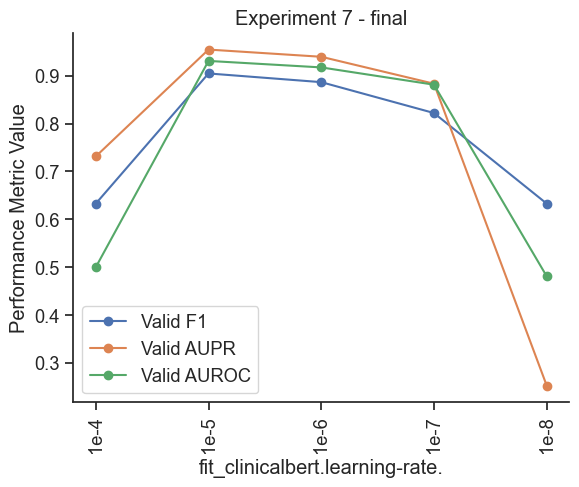

In [7]:
modeltype = 'final'
key = (modeltype, 'valid')
dfdata = {
    'Factor': experiment['labels'],
    'Valid Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Valid Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Valid F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Valid AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Valid AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
    'Threshold': [d['max_f1_threshold'] for d in perfdata[key]['prdata']]
}

valid = pd.DataFrame(dfdata)

key = (modeltype, 'test')
dfdata = {
#     'Factor': experiment['labels'],
    'Test Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Test Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Test F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Test AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Test AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

test = pd.DataFrame(dfdata)

sns.set(style='ticks', font_scale=1.2)

for col in ('Valid F1', 'Valid AUPR', 'Valid AUROC'):
    plt.plot(valid[col], 'o-', label=col)

plt.xticks(ticks = range(len(valid)), labels = valid['Factor'], rotation=90)
plt.xlabel(experiment['factor'])
plt.ylabel('Performance Metric Value')
plt.title(f"Experiment {experiment_id} - {modeltype}")
plt.legend()
sns.despine()

plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}-summary-stats.pdf')

pd.concat([valid, test], axis=1)

In [8]:
for fn in experiment['epochperf']:
    df = pd.read_csv(os.path.join('..', fn))
    print(fn, np.argmin(df['valid_loss']))

./results/epoch-results-CB_14-AR-125-all_222_24_25_0.0001_256_32.csv 4
./results/epoch-results-CB_14-AR-125-all_222_24_25_1e-05_256_32.csv 1
./results/epoch-results-CB_14-AR-125-all_222_24_25_1e-06_256_32.csv 9
./results/epoch-results-CB_14-AR-125-all_222_24_25_1e-07_256_32.csv 24
./results/epoch-results-CB_14-AR-125-all_222_24_25_1e-08_256_32.csv 24
